# Language Influence Social Network Patterns: A Case Study

### Introduction

In this project, we would like to play with the language feature from the original dataset. There has always been a stereotype that western people are more active on social media than eastern people. To verify such trends, we propose to analyze the features’ distribution of different language users. We can decide a user's activeness from some features such as tweet counts, friend numbers etc. Moreover, we would like to learn if language clusters exist on Twitter. If so, we want to learn to what extent they are going to interact with different clusters. In order to do so, we would run the community algorithm provided by networkx modules and see if we can detect the clusters of different language groups. In the end, we could apply machine learning to see if we can predict the language of a user based on the features of his/her own Twitter profile and that of the follower-followee network.

### Import Library

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import networkx as nx
from networkx.algorithms import community

### Load Profiles Dataset

Profiles dataset contains ID, followers count, friends count, statuses count, and language.

In [39]:
ego_alter_profiles = pd.read_csv("../Data/EgoAlterProfiles.txt", sep = '\t')

### Data Preprocess

##### 1. Filter out small languages

Since the number of users of some languages is too small, the result might have bias if we take these languages into account. Therefore, we decide to filter out languages which have less than 100 users.

##### 2.  Add area column

One of our research question is to find out whether western community and eastern community have different using behaviors on Twitter. In order to do so, we need to classify the languages to east or west before the analysis.

In [50]:
# I filter ego at the last step
# ego_alter_profiles=ego_alter_profiles[ ego_alter_profiles['IsEgo']==True ]

ego_alter_profiles['lang'] = ego_alter_profiles['lang'].str.lower()
ego_profiles = ego_alter_profiles[ ego_alter_profiles['IsEgo']==True ]

languages_count = ego_profiles.groupby('lang')['ID'].count().reset_index(name = 'count')
# I decreased this to a hundred
small_language = languages_count[languages_count['count'] < 100]['lang'].to_list()

languages_with_alter = ego_alter_profiles[ ~ego_alter_profiles['lang'].isin(small_language) ].reset_index(drop = True)
languages_with_alter = languages_with_alter[['ID','IsEgo', 'followers_count', 'friends_count', 'statuses_count', 'lang']]
languages_with_alter = languages_with_alter.dropna()

western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_language = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

western_language_ego = ['ru', 'fr', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en']
eastern_language_ego = ['ar', 'id', 'tr', 'ja', 'th', 'ko']

def classify_lang(lang):
    if lang in western_language:
        return 'West'
    if lang in eastern_language:
        return 'East'

languages_with_alter['area'] = languages_with_alter['lang'].apply(classify_lang)
languages = languages_with_alter[ languages_with_alter['IsEgo'] == True] 
languages.head()

ID  IsEgo  followers_count  friends_count  statuses_count lang  area
0   1   True             30.0             28             9.0   en  West
1   2   True              2.0              8             7.0   en  West
2   3   True              1.0              0             0.0   fr  West
3   4   True              3.0              3            68.0   en  West
4   5   True             65.0            118           748.0   fr  West

### Language Statistic

To get an overview of the dataset, we grouped the dataset by the language column and calculate the mean value of followers count, friends count, and statuses count among different languages.

In [4]:
languages_stat = (languages.groupby('lang')[['followers_count', 'friends_count', 'statuses_count']]
.mean()
.reset_index())

languages_count_dict = dict(zip(languages_count['lang'], languages_count['count']))

def add_count(lang):
    return languages_count_dict[lang]

languages_stat['user_count'] = languages_stat['lang'].apply(add_count)
languages_stat['area'] = languages_stat['lang'].apply(classify_lang)
languages_stat.set_index('lang', inplace = True)
languages_stat.sort_values(by = 'user_count', inplace = True)

languages_stat.head()

followers_count  friends_count  statuses_count  user_count  area
lang                                                                   
en-gb       136.120000      91.857143      174.377143         175  West
th            5.358289      32.176471      308.090909         187  East
nl           37.544554      53.965347      863.851485         202  West
de           46.207977      71.609687       83.703704         351  West
it           19.535714      46.319048      155.814286         420  West

### Data Exploration

From the figures below, we can figure out the language composition of the dataset.

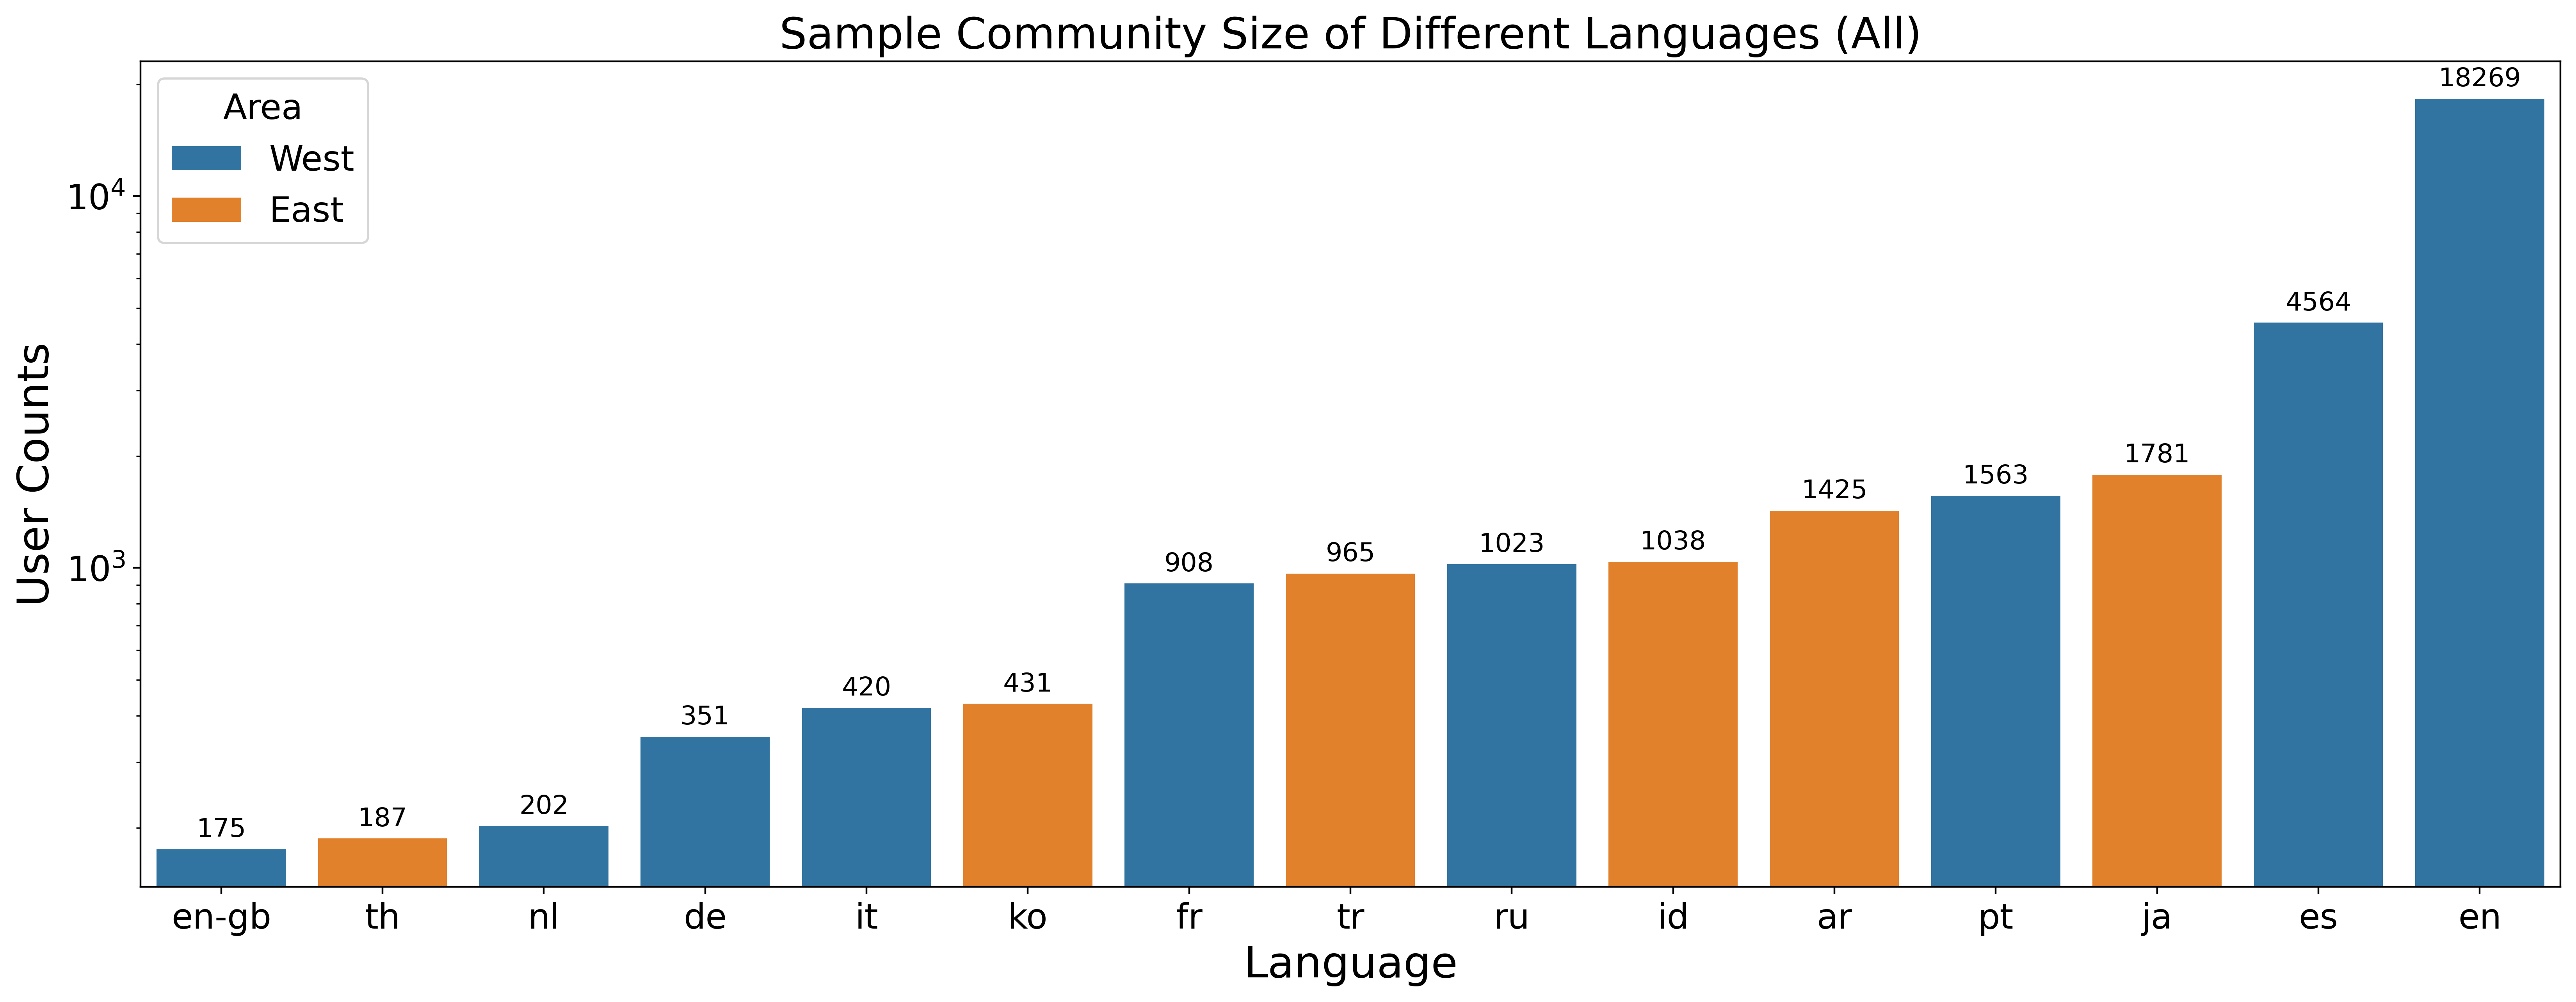

In [5]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat.index, y = languages_stat['user_count'], hue = languages_stat['area'], ax = ax,
           dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (All)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
plt.legend(title="Area", fontsize=16, title_fontsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 
plt.show()

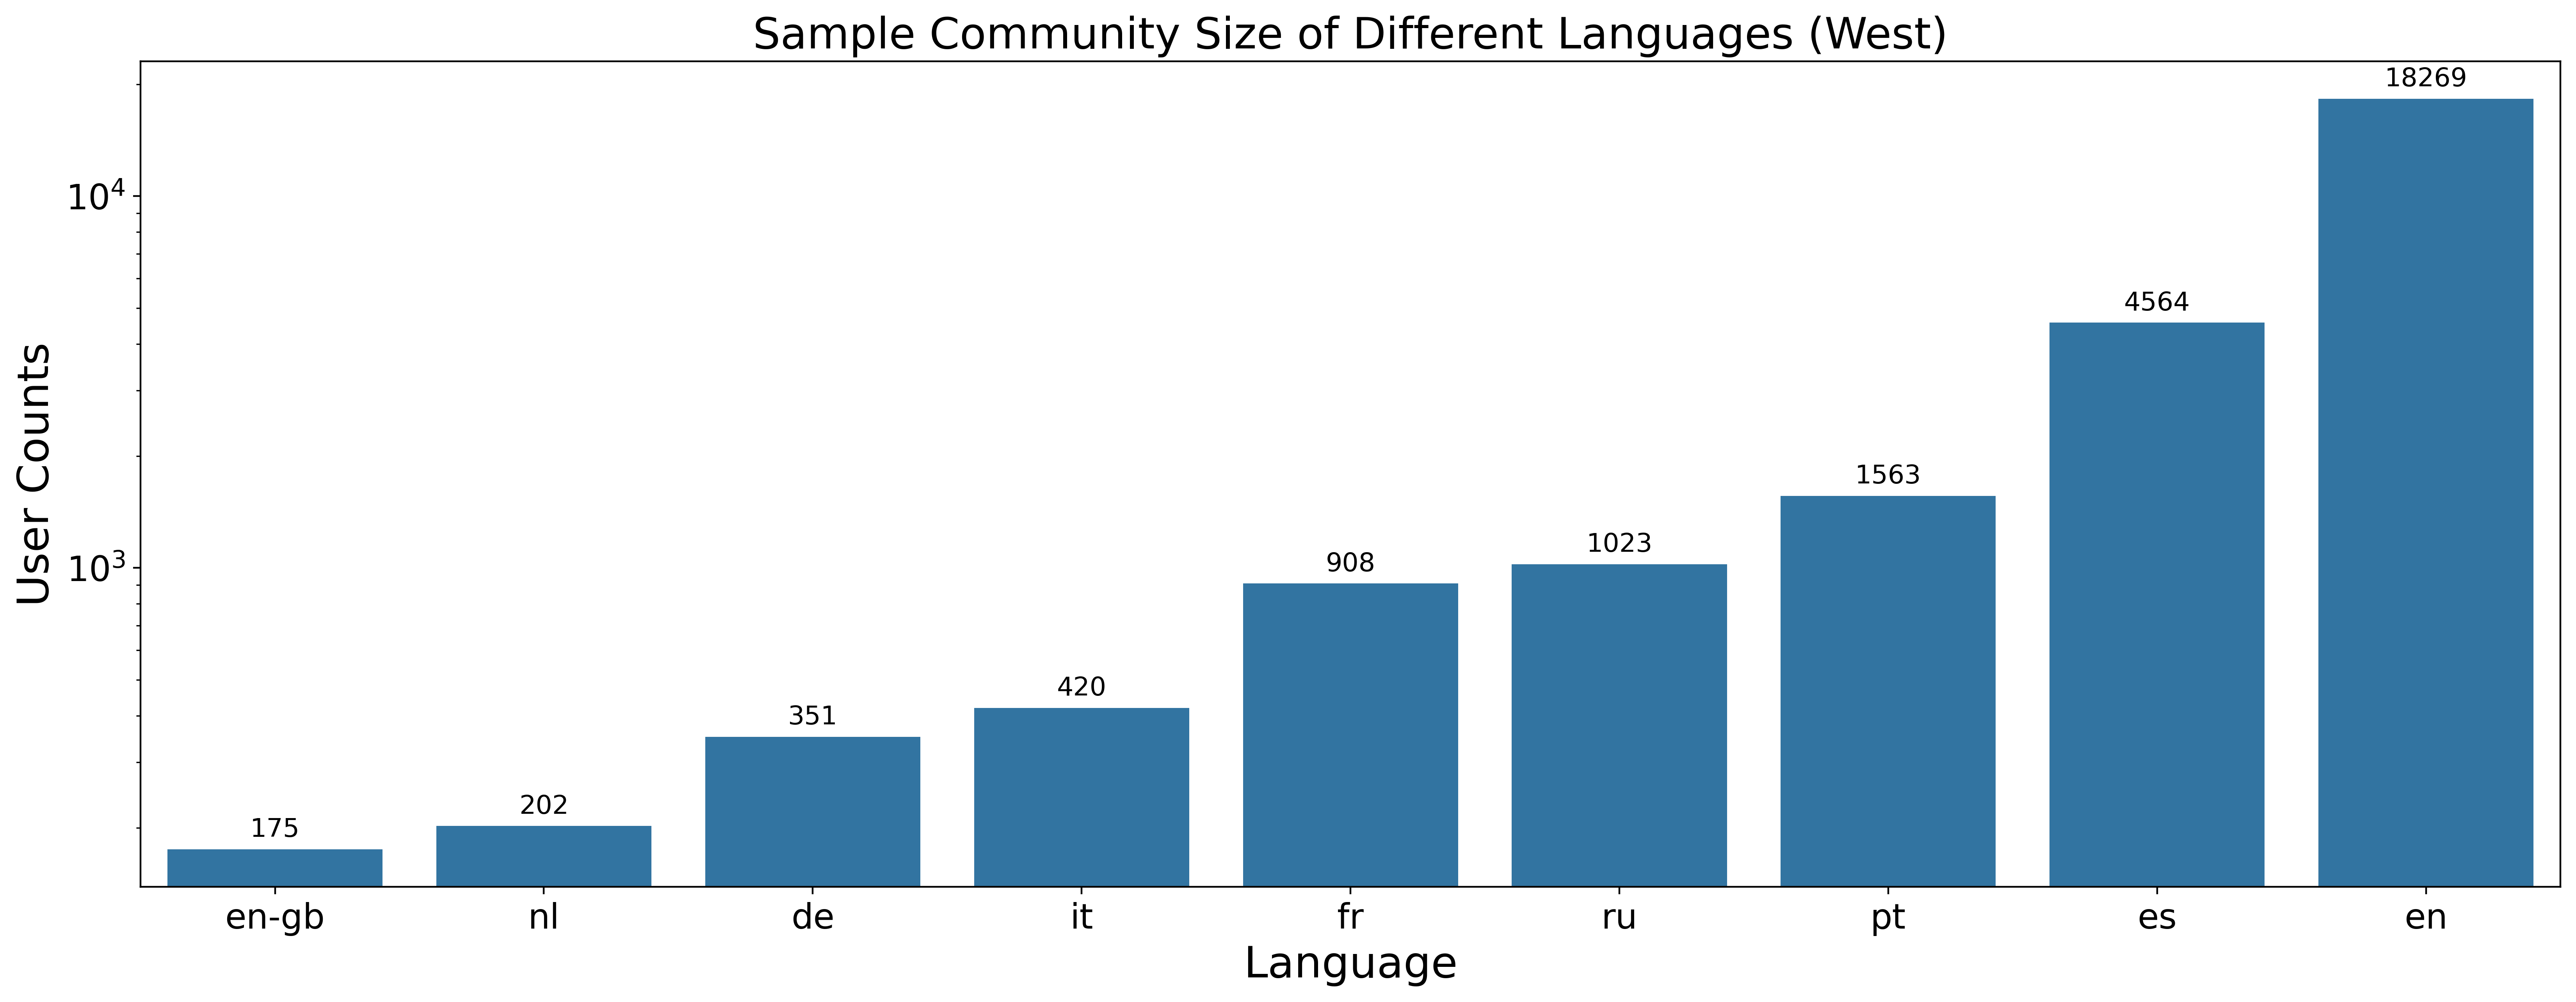

In [6]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_west = languages_stat[languages_stat['area']=='West']

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_west.index, y = languages_stat_west['user_count'], 
            color = sns.color_palette()[0], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (West)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12) 

plt.show()

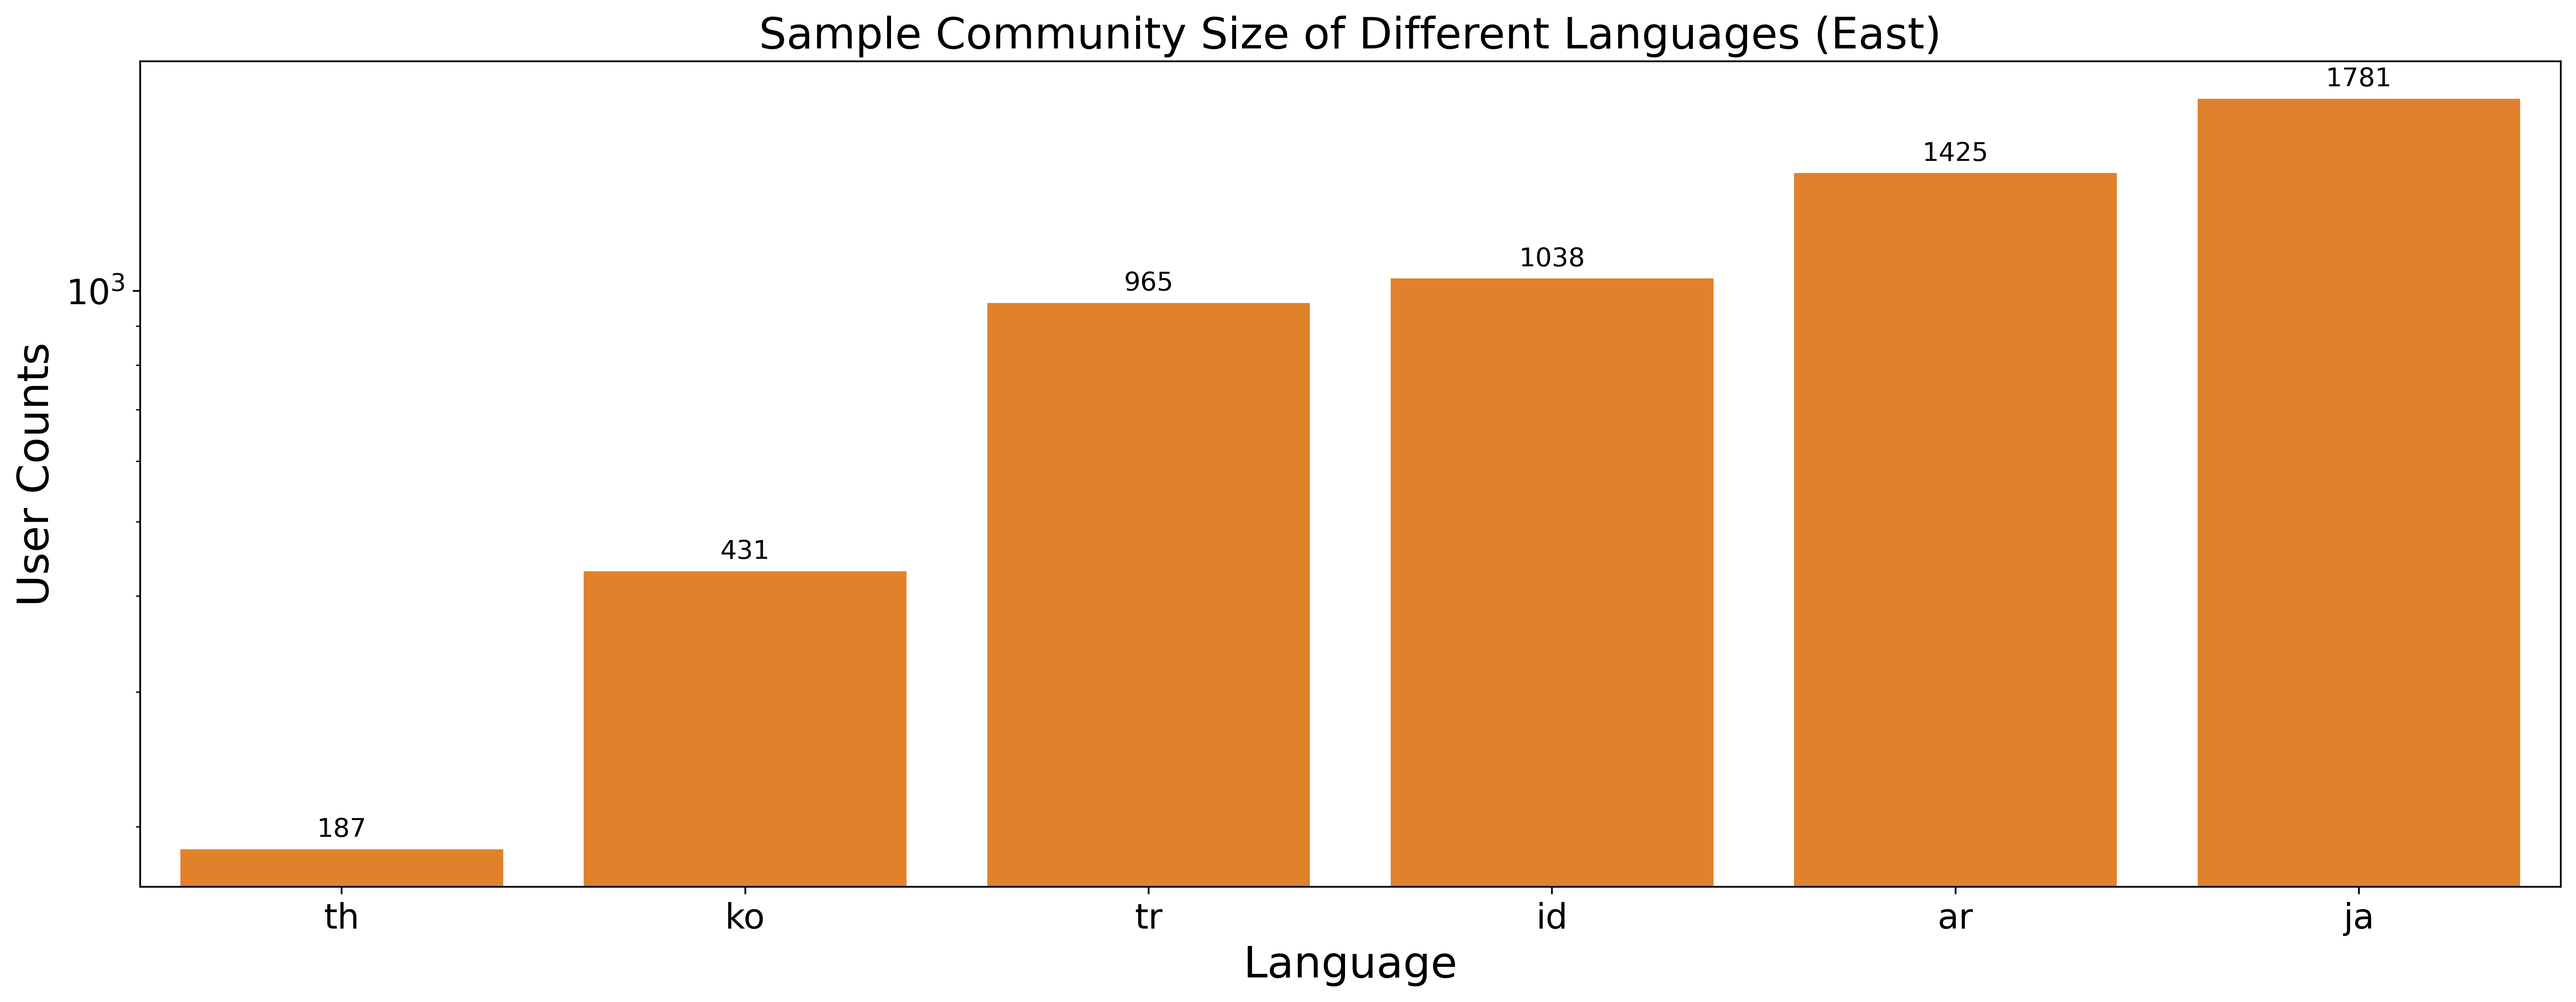

In [7]:
fig, ax = plt.subplots(figsize = (20, 7), dpi = 400)

languages_stat_east = languages_stat[languages_stat['area']=='East']

ax.set(yscale = 'log')
splot = sns.barplot(x = languages_stat_east.index, y = languages_stat_east['user_count'], 
            color = sns.color_palette()[1], ax = ax, dodge = False)
ax.set_xlabel('Language', fontsize = 20)
ax.set_ylabel('User Counts', fontsize = 20)
ax.set_title('Sample Community Size of Different Languages (East)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize = 12,) 

plt.show()

### Data Exploration

From the figures below, we can understand the distribution of the features of different languages.

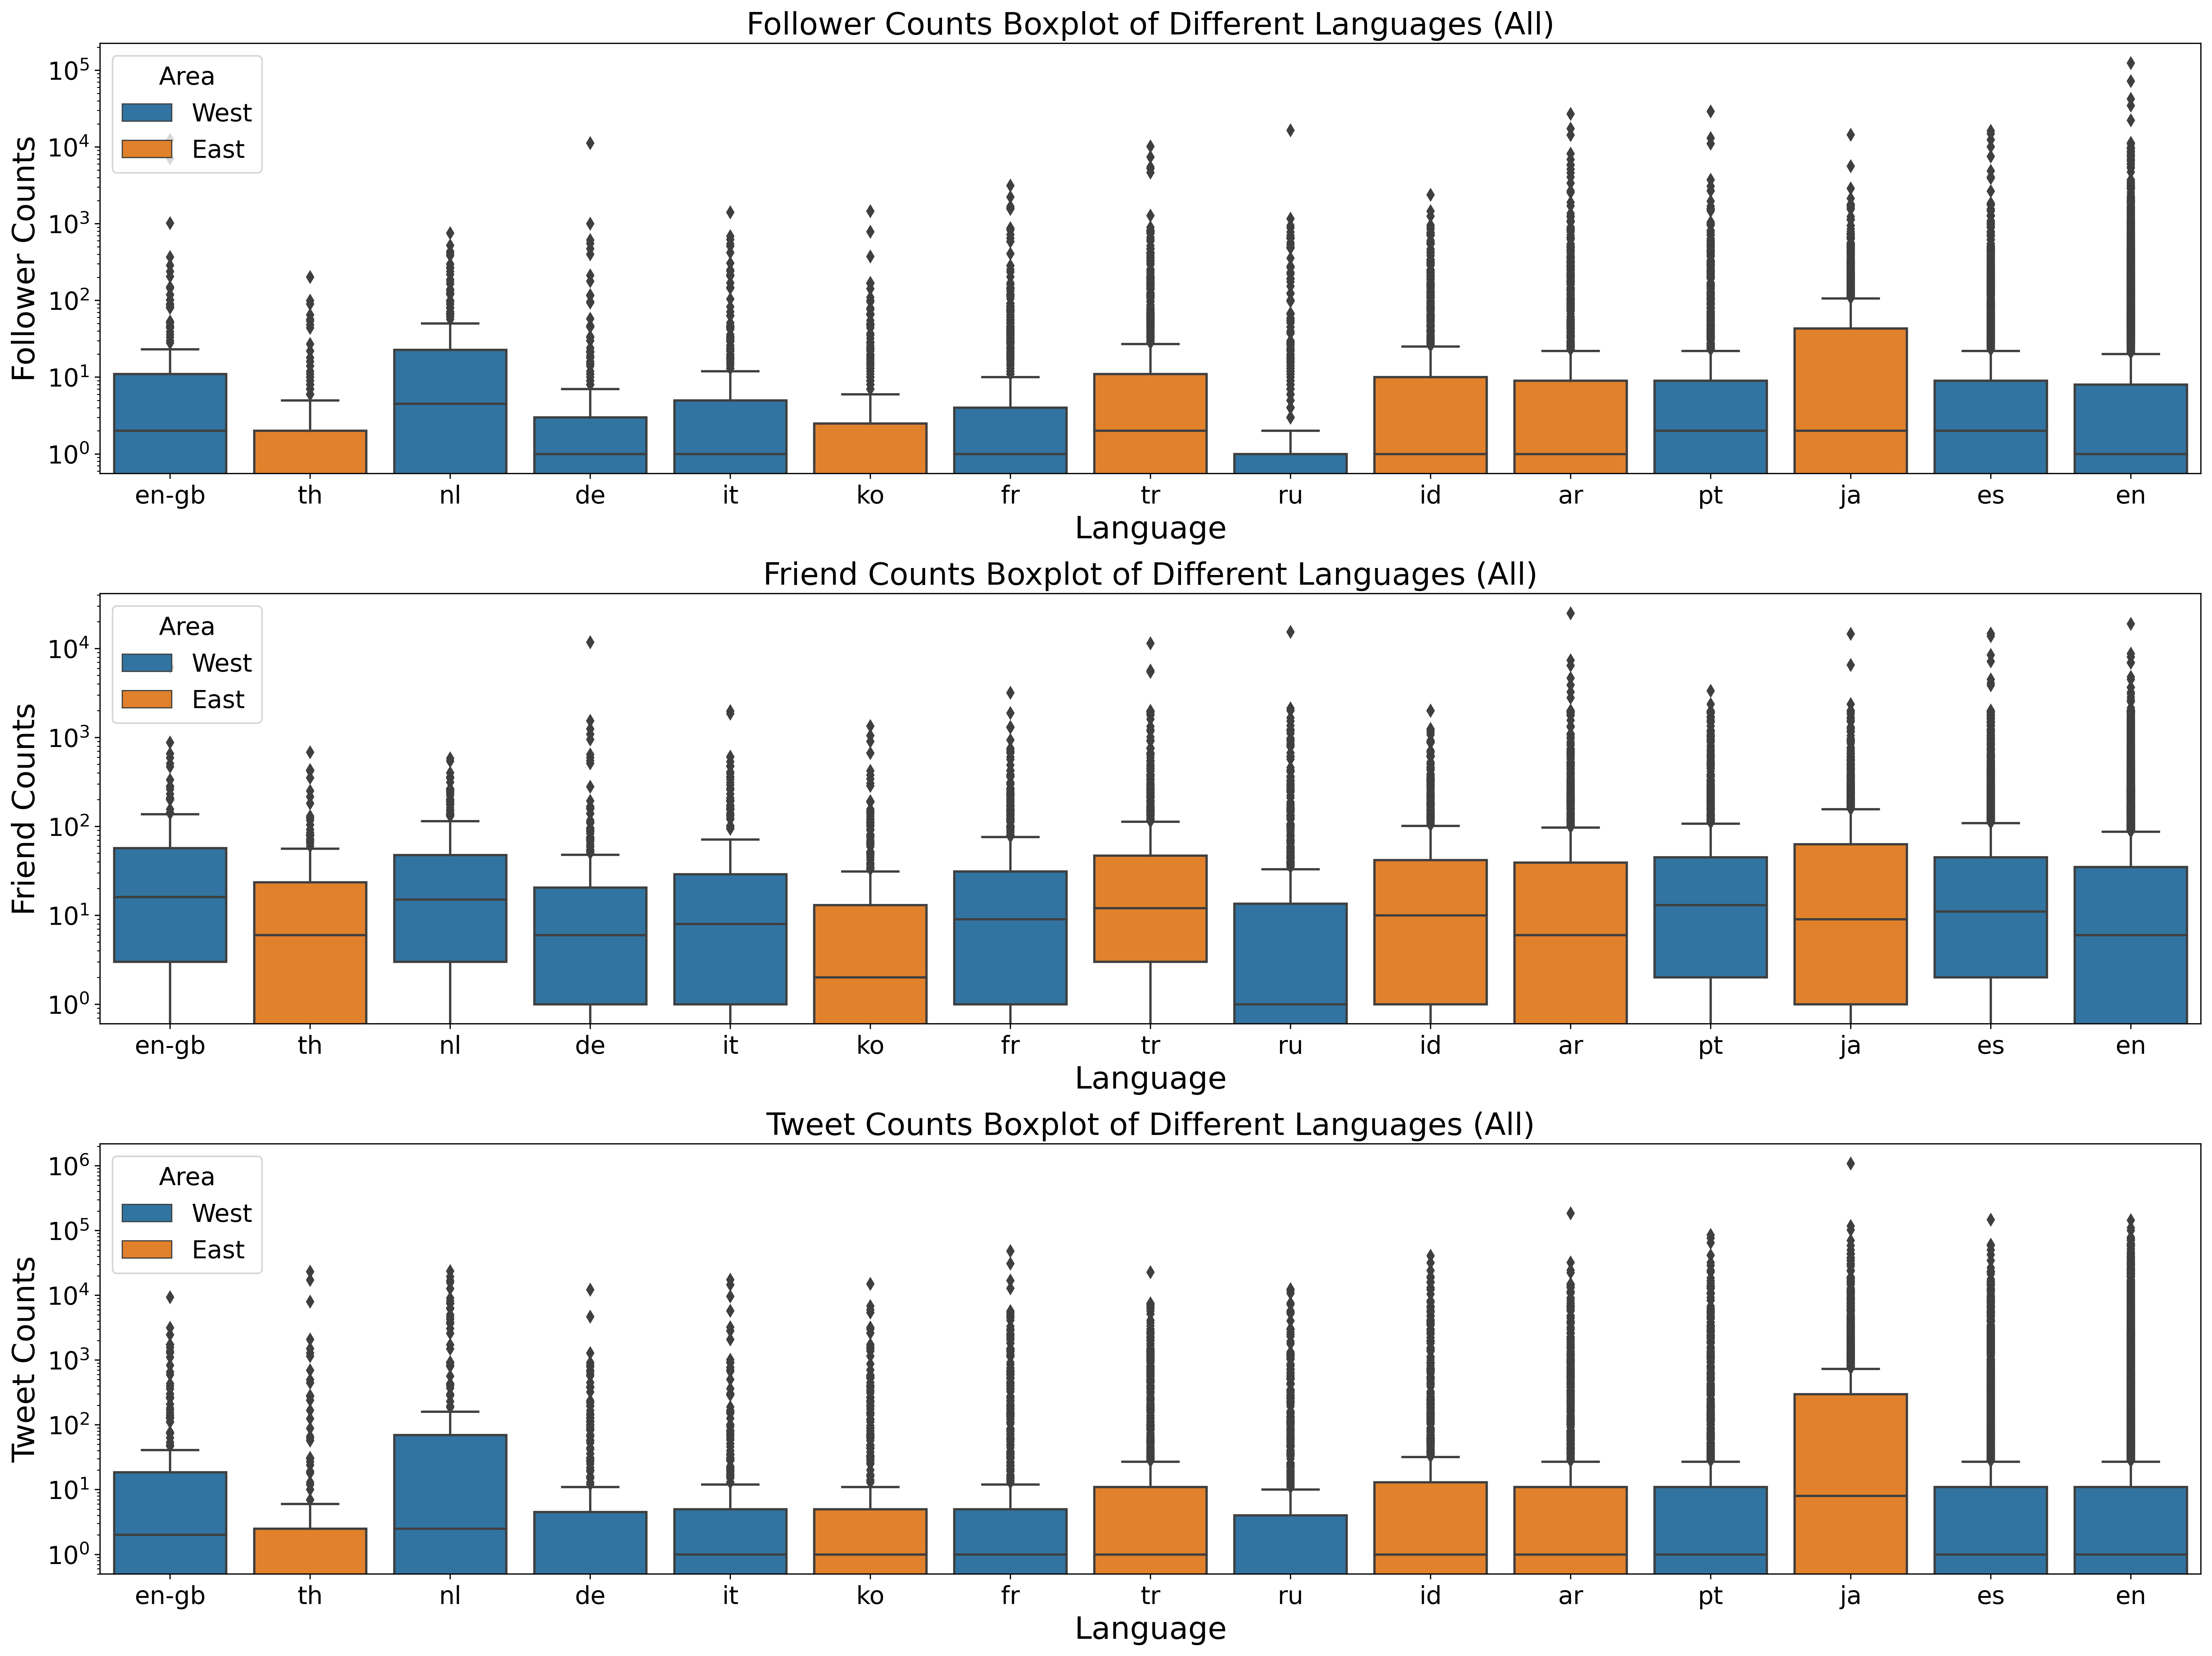

In [8]:
language_order = languages_stat.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages, order = language_order, ax = ax[0],
           hue = 'area', dodge = False)
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (All)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)
ax[0].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages, order = language_order, ax = ax[1],
           hue = 'area', dodge = False)
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (All)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)
ax[1].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages, order = language_order, ax = ax[2],
           hue = 'area', dodge = False)
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (All)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)
ax[2].legend(title="Area", fontsize=16, title_fontsize=16, loc = 2)

fig.tight_layout()
plt.show()

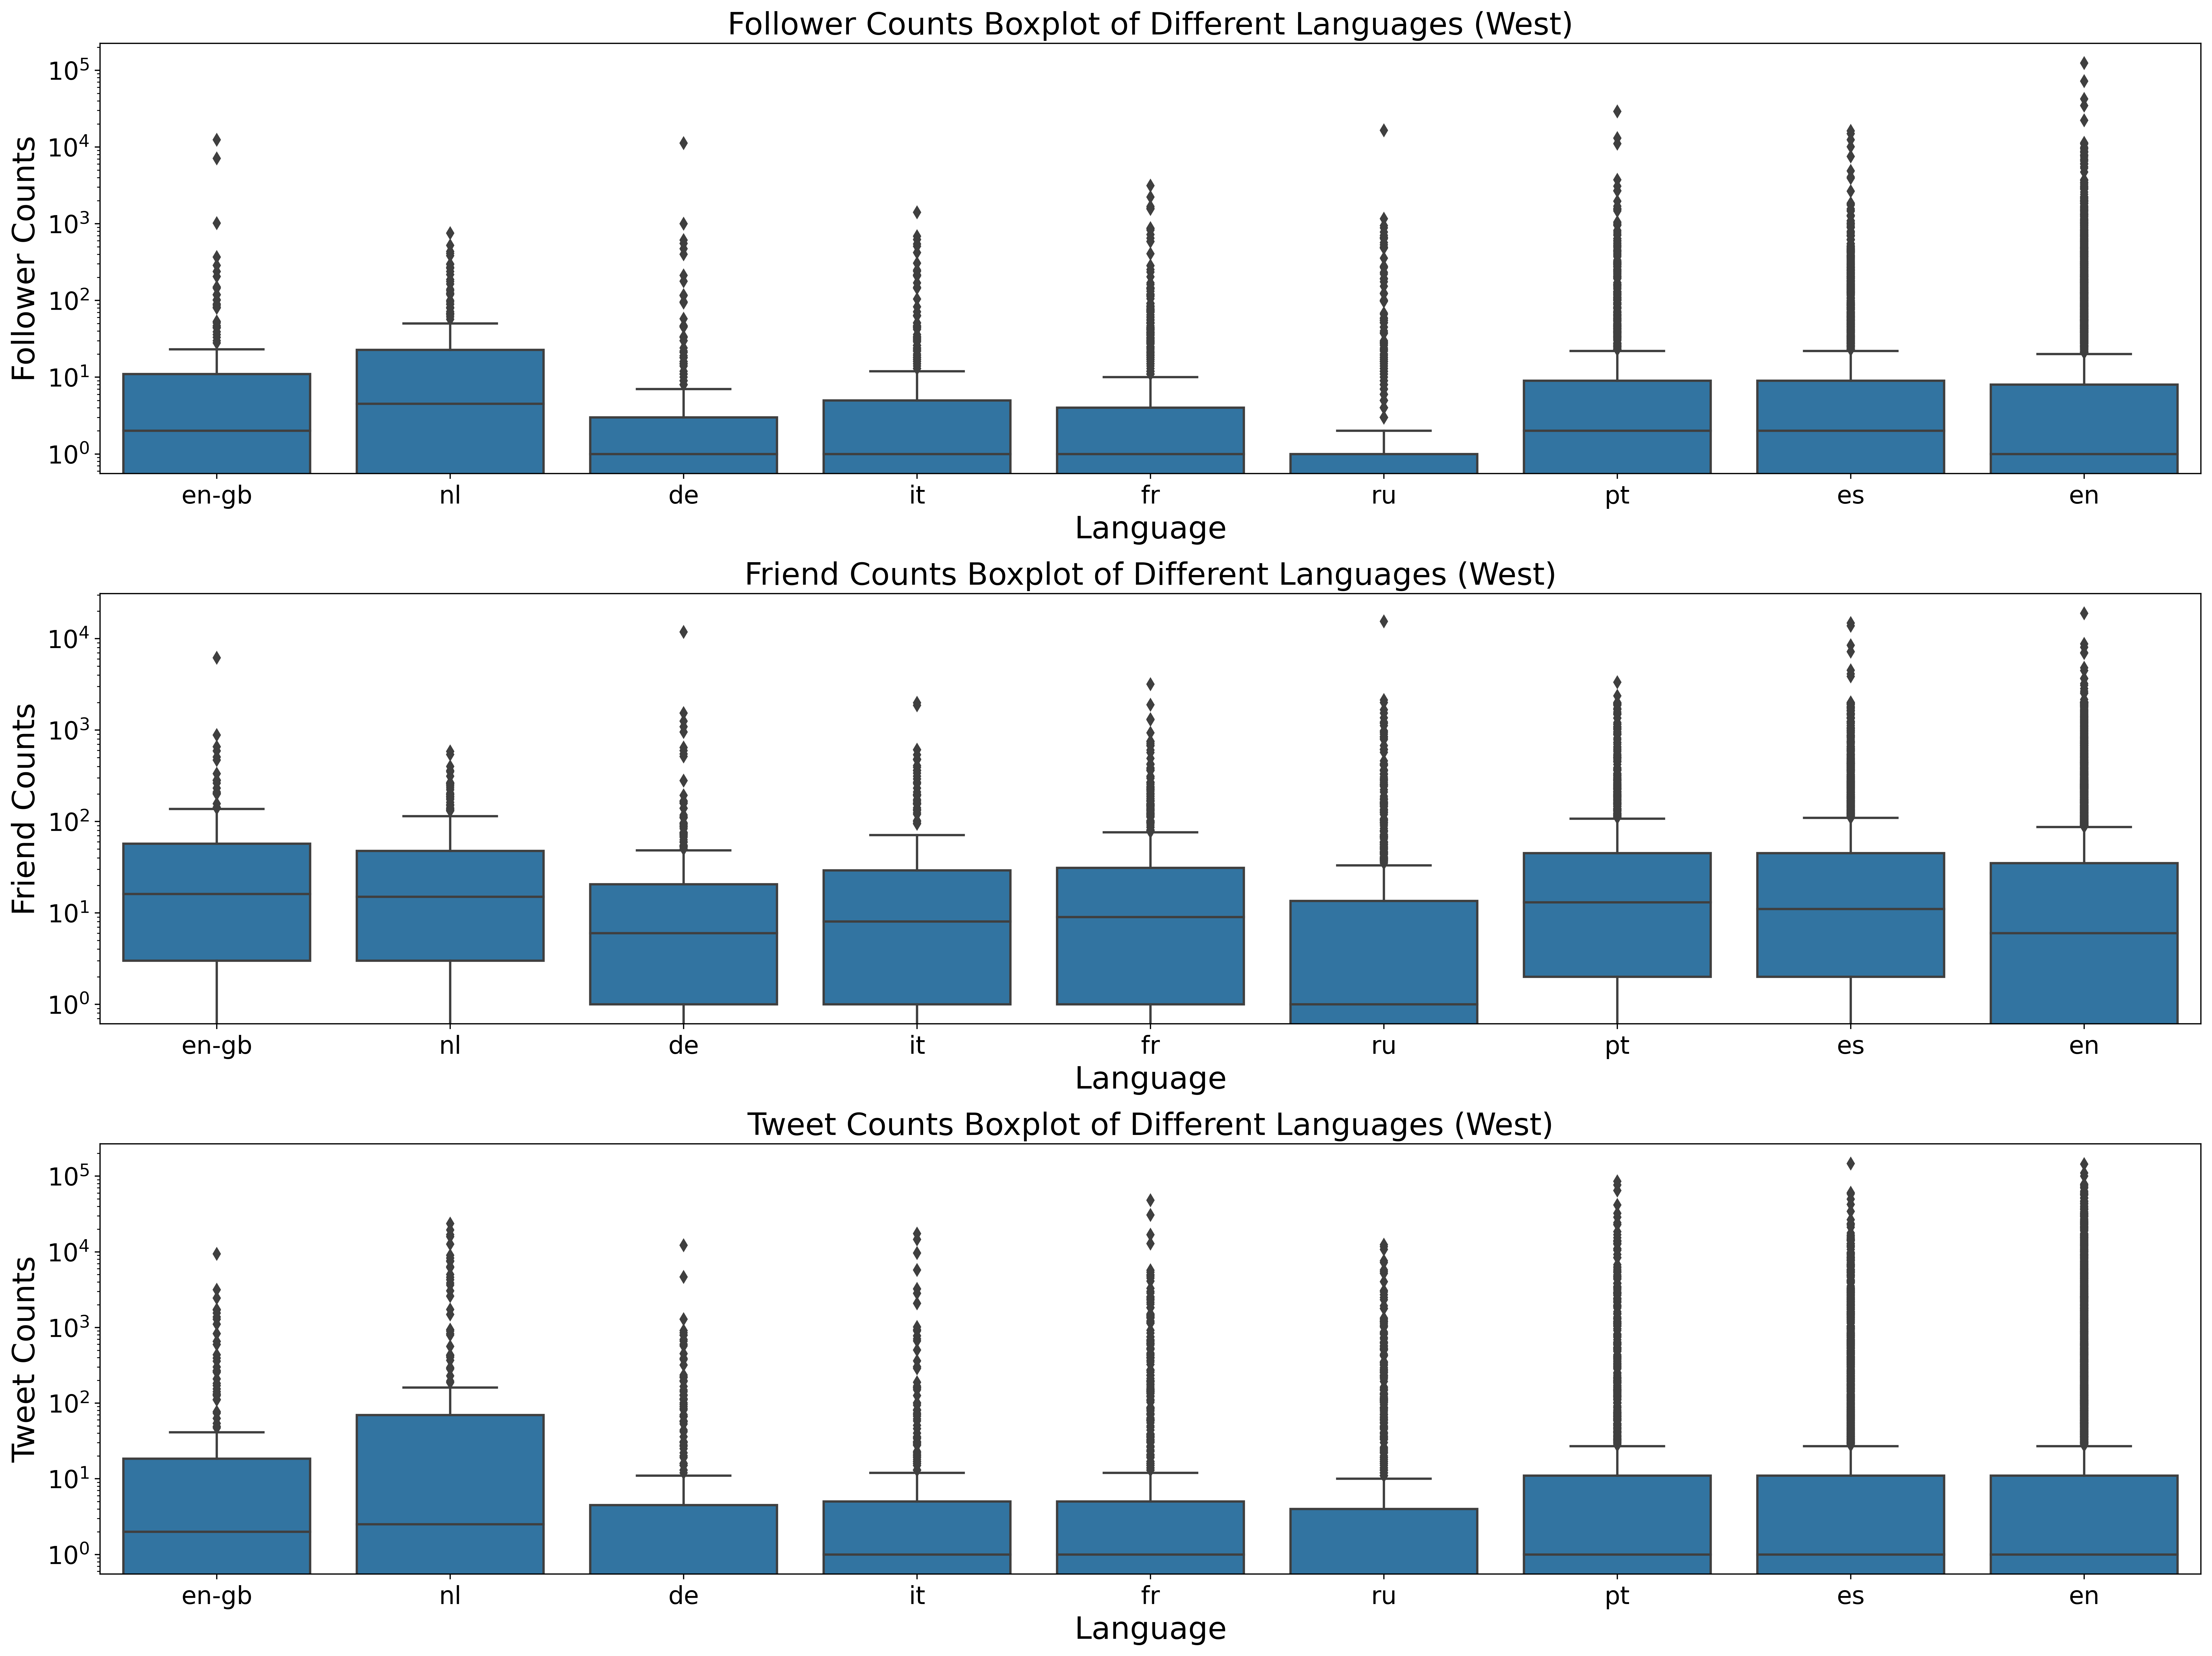

In [9]:
languages_west = languages[languages['area'] == 'West']
language_order = languages_stat_west.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages_west, order = language_order, ax = ax[0],
            dodge = False, color = sns.color_palette()[0])
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (West)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages_west, order = language_order, ax = ax[1],
           dodge = False, color = sns.color_palette()[0])
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (West)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages_west, order = language_order, ax = ax[2],
           dodge = False, color = sns.color_palette()[0])
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (West)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

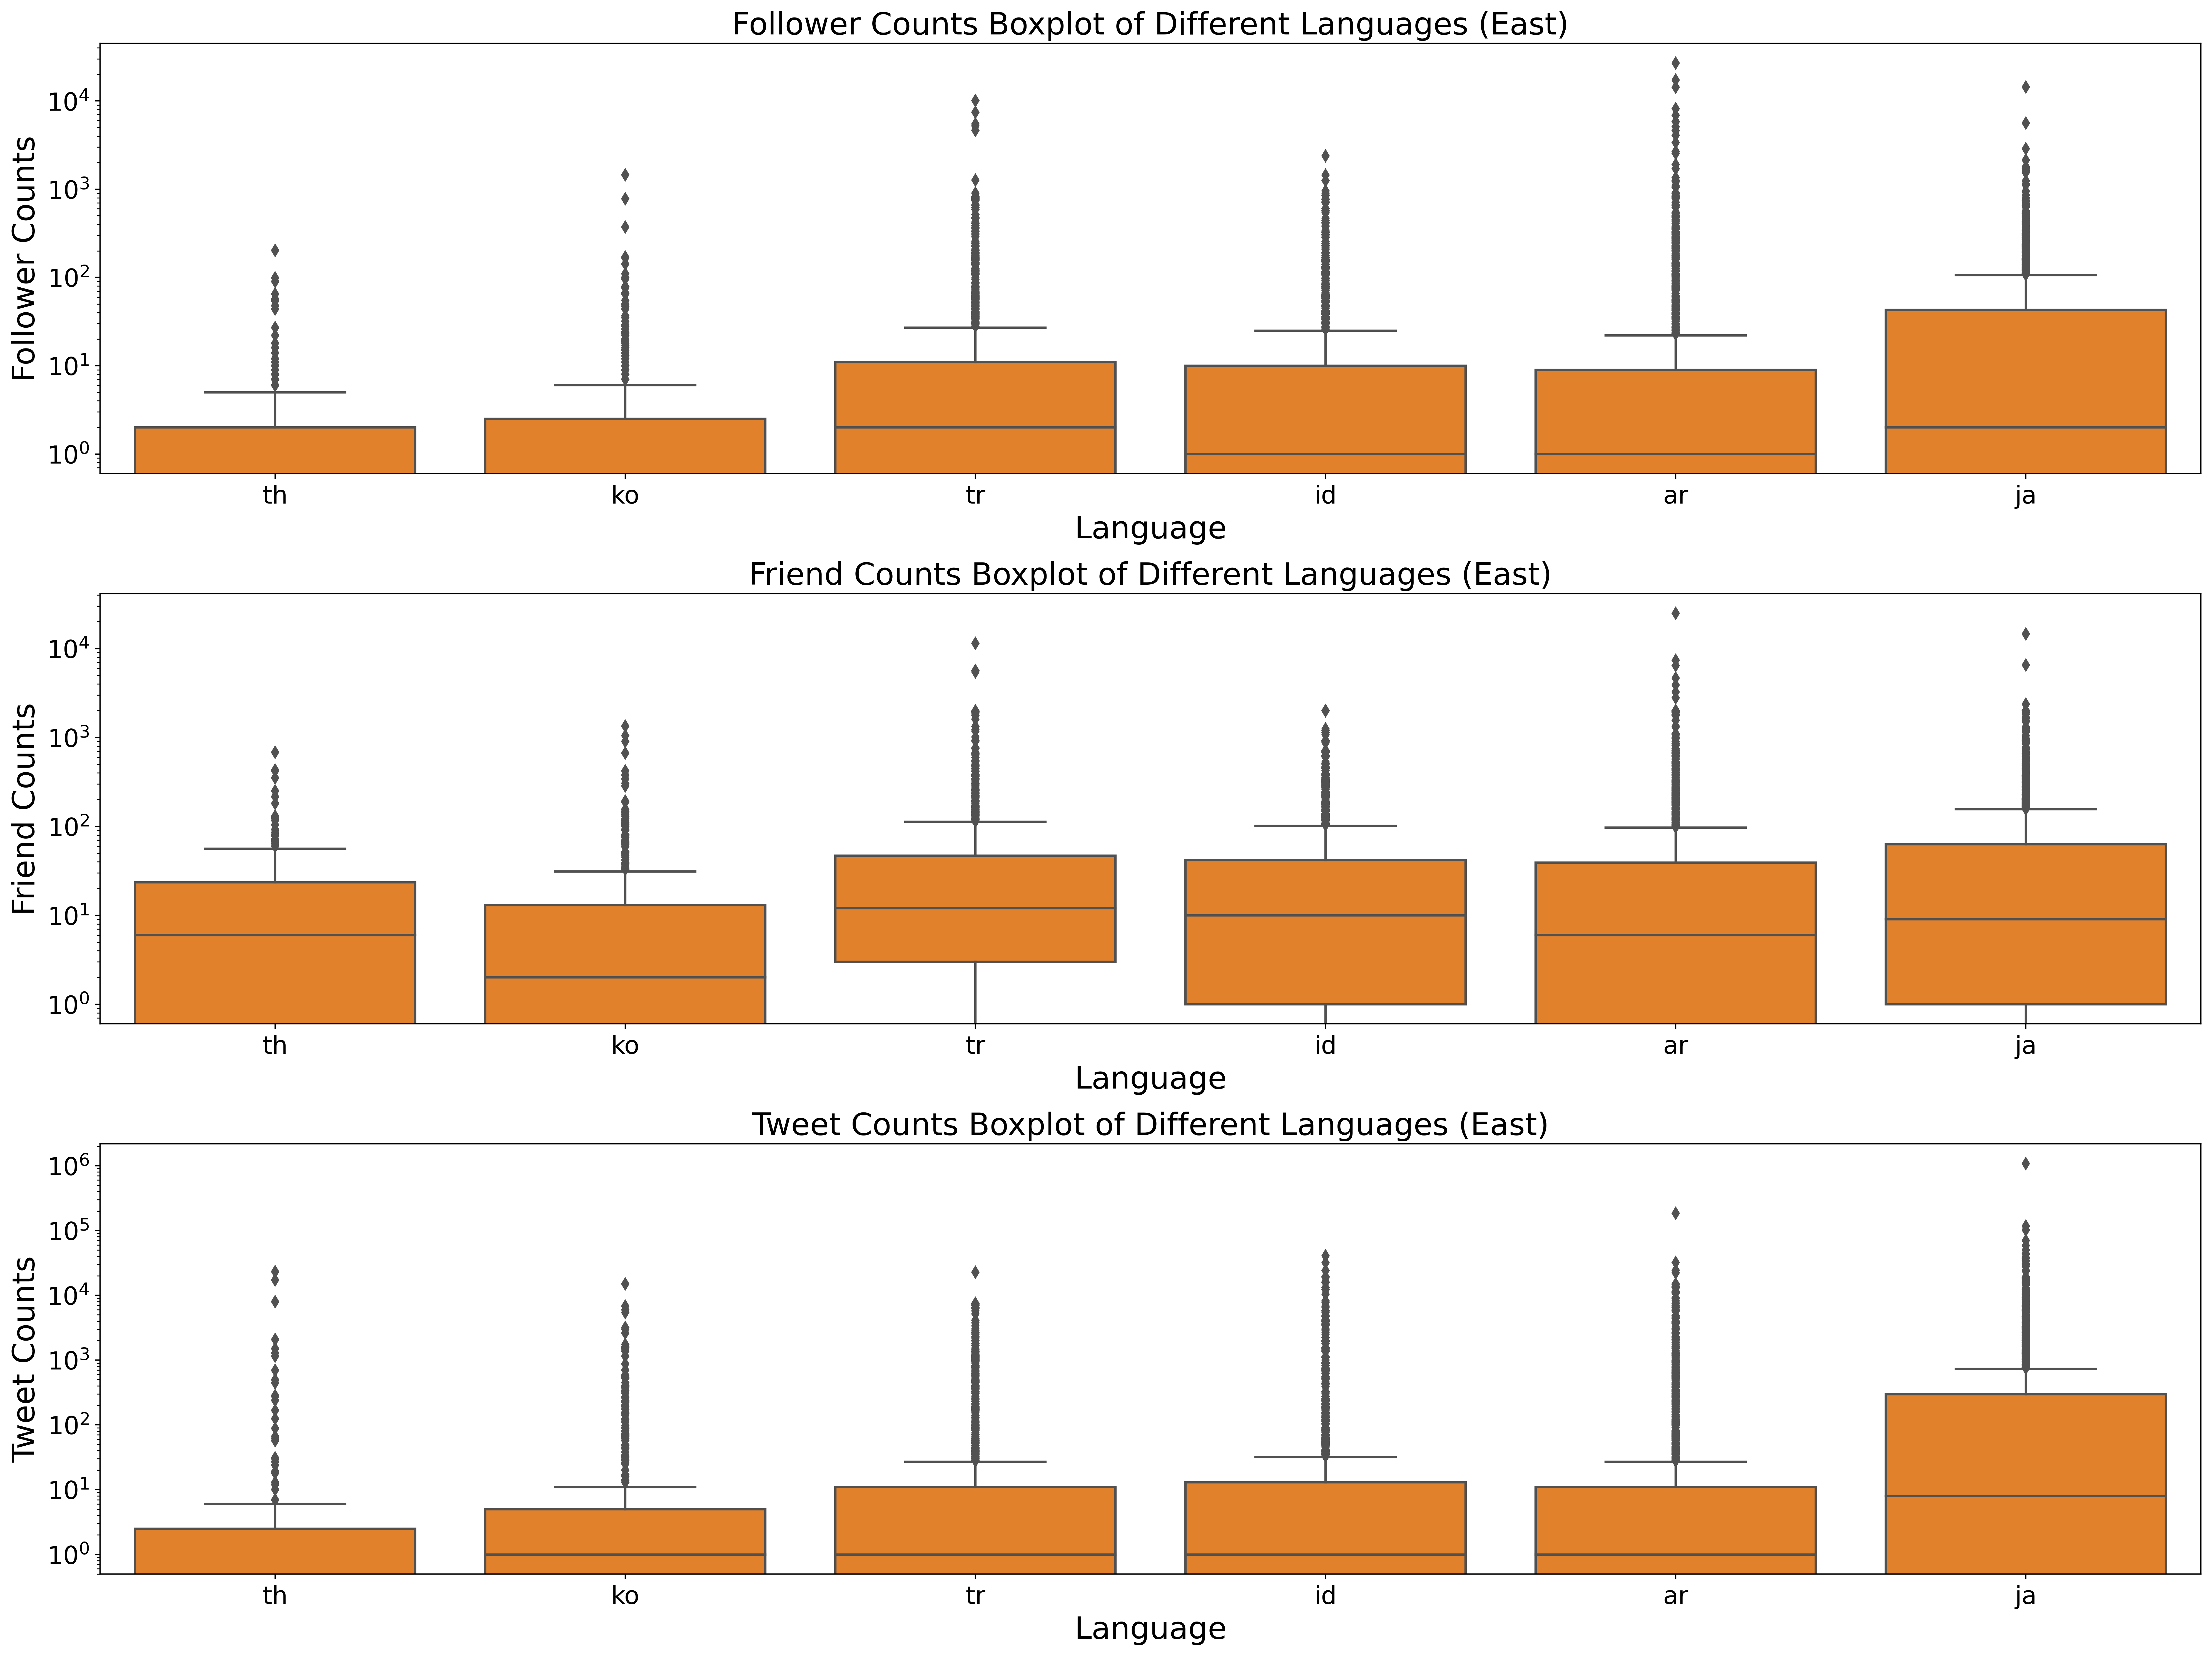

In [10]:
languages_east = languages[languages['area'] == 'East']
language_order = languages_stat_east.index.tolist()

fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(yscale="log")
sns.boxplot(x = 'lang', y = 'followers_count', data = languages_east, order = language_order, ax = ax[0],
           dodge = False, color = sns.color_palette()[1])
ax[0].set_xlabel('Language', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Languages (East)', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(yscale="log")
sns.boxplot(x = 'lang', y = 'friends_count', data = languages_east, order = language_order, ax = ax[1],
           dodge = False, color = sns.color_palette()[1])
ax[1].set_xlabel('Language', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Languages (East)', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(yscale="log")
sns.boxplot(x = 'lang', y = 'statuses_count', data = languages_east, order = language_order, ax = ax[2],
           dodge = False, color = sns.color_palette()[1])
ax[2].set_xlabel('Language', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Languages (East)', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

### Relation Between Community Size and Each Feature

In the begining of our analysis, we would like to see if the community size are correlated to some features such as friends count or tweets count. The figure below and the **pearson's correlated coefficient** shows that no features are correlated to the community size.

0.08188169974584418
0.08164986987448364
0.048256357545244516


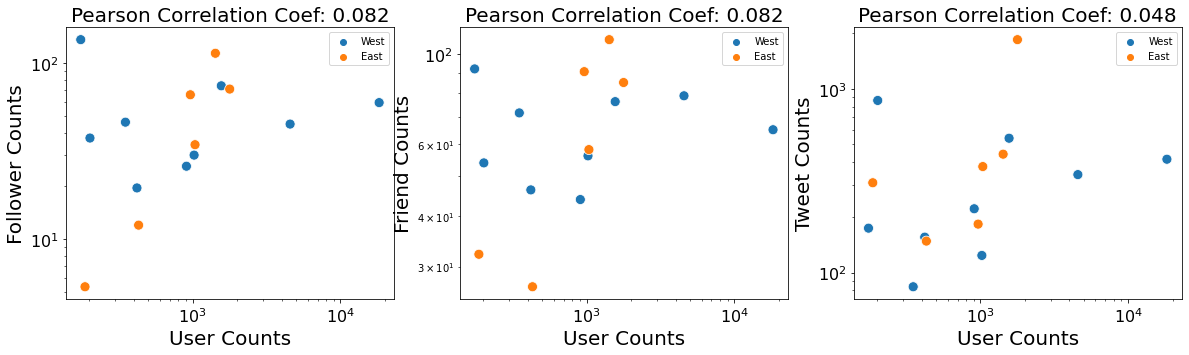

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (20, 5))

ax[0].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'followers_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[0], s=100)
ax[0].set_xlabel('User Counts', fontsize = 20)
ax[0].set_ylabel('Follower Counts', fontsize = 20)
ax[0].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'friends_count', hue=languages_stat.area.tolist(),
                data = languages_stat, ax = ax[1], s = 100)
ax[1].set_xlabel('User Counts', fontsize = 20)
ax[1].set_ylabel('Friend Counts', fontsize = 20)
ax[1].set_title('Pearson Correlation Coef: 0.082', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(xscale="log", yscale='log')
sns.scatterplot(x = 'user_count', y = 'statuses_count', hue=languages_stat.area.tolist(), 
                data = languages_stat, ax = ax[2], s=100)
ax[2].set_xlabel('User Counts', fontsize = 20)
ax[2].set_ylabel('Tweet Counts', fontsize = 20)
ax[2].set_title('Pearson Correlation Coef: 0.048', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

print(languages_stat['user_count'].corr(languages_stat['followers_count']))
print(languages_stat['user_count'].corr(languages_stat['friends_count']))
print(languages_stat['user_count'].corr(languages_stat['statuses_count']))

### Data Exploration for Cultures

To figure out whether the difference exists among western countries and eastern countries. We then group the users by the area, and check the distribution of each feature.

In [12]:
languages.groupby('area')[['followers_count', 'friends_count', 'statuses_count']].mean().reset_index()

area  followers_count  friends_count  statuses_count
0  East        67.785653      80.855157      791.880556
1  West        55.424750      66.884513      385.208371

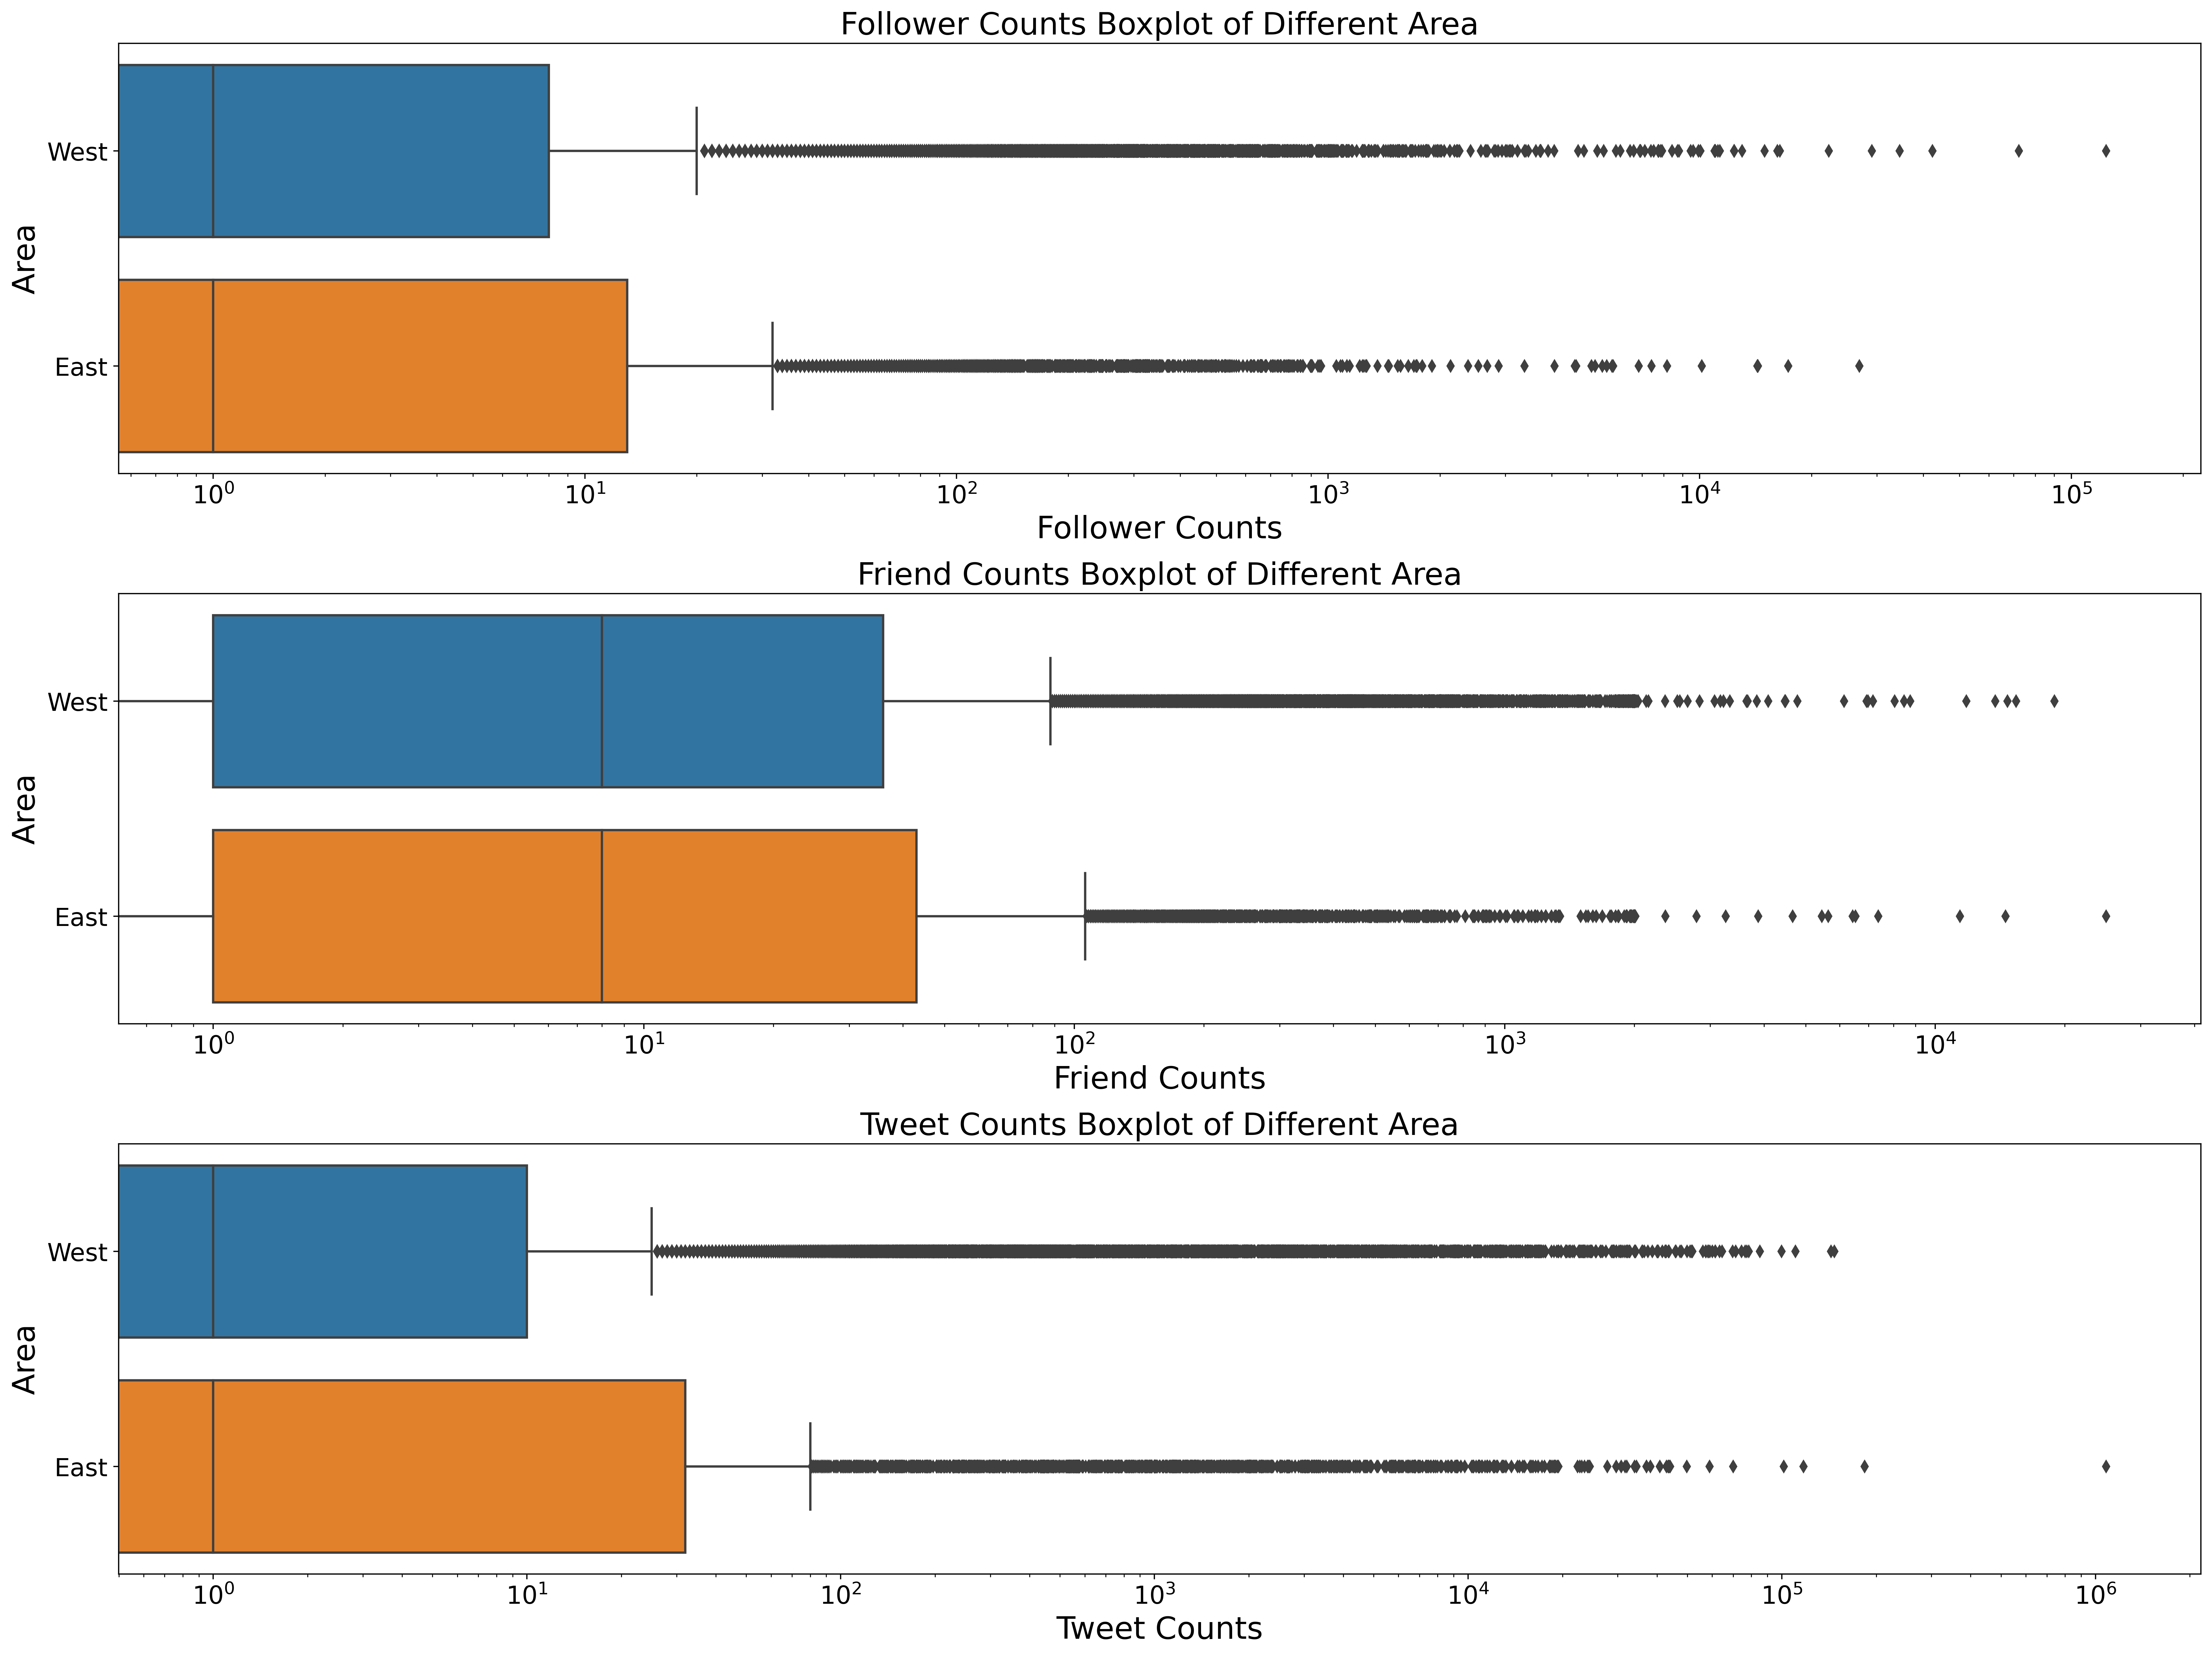

In [13]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15), dpi = 400)

ax[0].set(xscale="log")
sns.boxplot( x = 'followers_count', y = 'area', data = languages, ax = ax[0])
ax[0].set_xlabel('Follower Counts', fontsize = 20)
ax[0].set_ylabel('Area', fontsize = 20)
ax[0].set_title('Follower Counts Boxplot of Different Area', fontsize=20)
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

ax[1].set(xscale="log")
sns.boxplot( x = 'friends_count', y = 'area', data = languages, ax = ax[1])
ax[1].set_xlabel('Friend Counts', fontsize = 20)
ax[1].set_ylabel('Area', fontsize = 20)
ax[1].set_title('Friend Counts Boxplot of Different Area', fontsize=20)
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

ax[2].set(xscale="log")
sns.boxplot( x = 'statuses_count', y = 'area',  data = languages, ax = ax[2])
ax[2].set_xlabel('Tweet Counts', fontsize = 20)
ax[2].set_ylabel('Area', fontsize = 20)
ax[2].set_title('Tweet Counts Boxplot of Different Area', fontsize=20)
ax[2].xaxis.set_tick_params(labelsize=16)
ax[2].yaxis.set_tick_params(labelsize=16)

fig.tight_layout()
plt.show()

In [14]:
a = languages_east['followers_count'].tolist()
b = languages_west['followers_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['friends_count'].tolist()
b = languages_west['friends_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))

a = languages_east['statuses_count'].tolist()
b = languages_west['statuses_count'].tolist()
print(stats.kstest(a, b))
print(stats.ttest_ind(a, b))


KstestResult(statistic=0.05966112069992646, pvalue=2.5754516147654135e-15)
Ttest_indResult(statistic=0.8896289697859583, pvalue=0.37367157207844126)
KstestResult(statistic=0.02660719848754023, pvalue=0.002173285864558884)
Ttest_indResult(statistic=2.781594494565227, pvalue=0.005412299219733745)
KstestResult(statistic=0.07848482941494939, pvalue=3.348036553972356e-26)
Ttest_indResult(statistic=4.135956809708513, pvalue=3.543449863324993e-05)


### Case Study for different cultures

To delve deeper into the difference between eastern contries and western countries, we then try to reproduce some figures in the paper but group it by different cultures.

##### 1. Distribution of the number of tweets per user

Figures show the distribution of eastern countries and western countries are almost the same.

In [15]:
user_profiles = pd.read_csv('../Data/EgoAlterProfiles.txt', sep = '\t')

In [16]:
user_profiles = user_profiles[user_profiles['IsEgo'] == True]
user_profiles['lang'] = user_profiles['lang'].str.lower()

In [17]:
western_language = ['bg', 'ca', 'cs', 'da', 'de', 'el', 'en', 'en-au', 'en-gb', 'es', 'es-mx', 'eu', 'fa',
                 'fi',  'fr', 'he', 'hi', 'hr', 'hu',   'it', 'ka', 'lv', 'nb', 'nl', 'no', 'pl', 'pt',
                 'pt-pt', 'ro', 'ru', 'sr', 'sv', 'uk']

eastern_langauge = ['ar', 'az', 'fil', 'id', 'in', 'ja', 'ko', 'ms', 'msa', 'th', 'tr', 'vi' , 'zh', 'zh-cn',
                    'zh-hans', 'zh-hant', 'zh-tw']

In [18]:
# filter the ego user and sort it by 'statuses_count'
ego = user_profiles[user_profiles['IsEgo'] == True]
ego_west = user_profiles[user_profiles['lang'].isin(western_language)]
ego_west = ego_west.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

ego_east = user_profiles[user_profiles['lang'].isin(eastern_language)]
ego_east = ego_east.sort_values(by = ['statuses_count'], ascending = False).reset_index(drop=True)

# check the number of egos and the data
#print(ego_west.shape)
#ego_west.head()

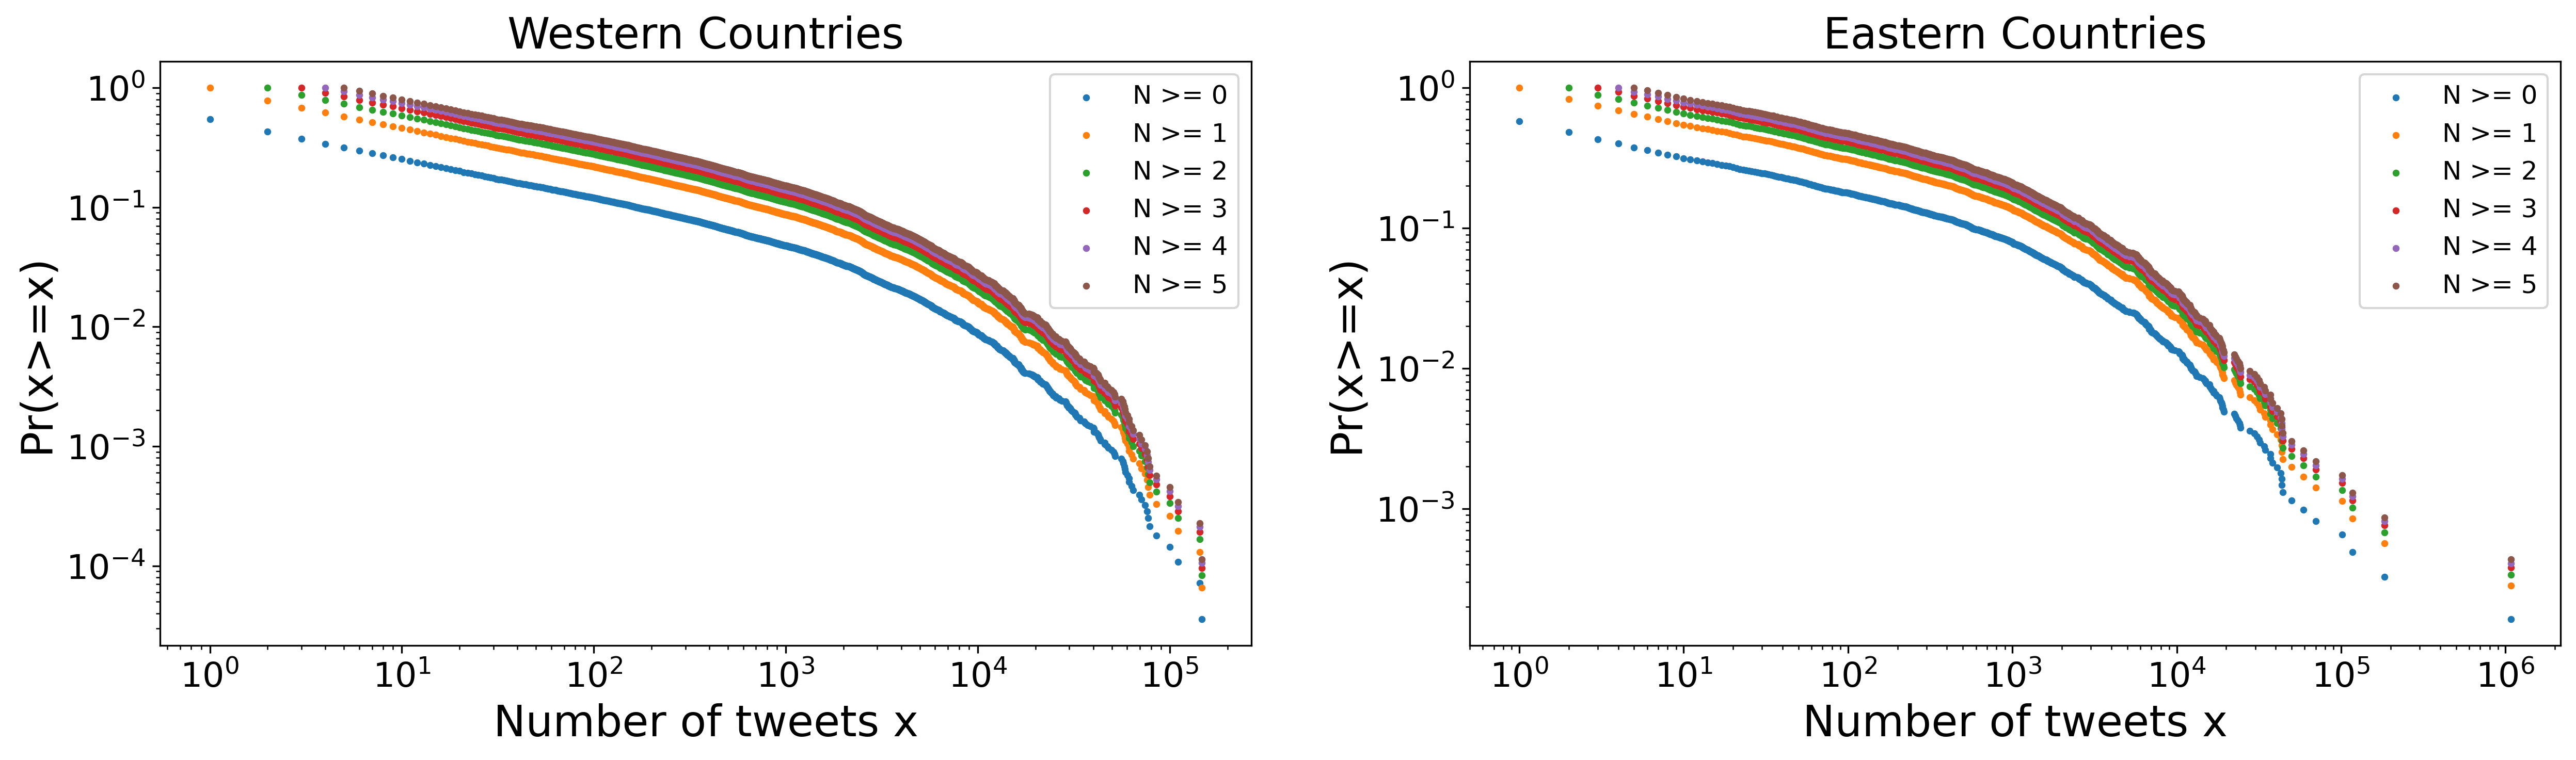

In [19]:
# prepare for the plot

fig, ax = plt.subplots(1, 2, figsize = (20, 5), dpi = 300)

# western plot

ax[0].set_title('Western Countries', fontsize = 20)
ax[0].set_xlabel('Number of tweets x', fontsize=20)
ax[0].set_ylabel('Pr(x>=x)', fontsize=20)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=16)
ax[0].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_west.groupby(ego_west['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[0].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[0].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

# eastern plot

ax[1].set_title('Eastern Countries', fontsize = 20)
ax[1].set_xlabel('Number of tweets x', fontsize=20)
ax[1].set_ylabel('Pr(x>=x)', fontsize=20)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=16)
ax[1].yaxis.set_tick_params(labelsize=16)

# calculate the number of people for each tweet counts 
temp = ego_east.groupby(ego_east['statuses_count']).count()['ID']
temp = temp.sort_index(ascending = False)

# loop the threshold from 0 to 5
for N in range(0, 6):
    temp = temp[temp.index >= N]
    tweet = temp.index.to_list()
    count = temp.to_list()
    total = np.sum(count)
    
    # cumulate tweet counts
    for i in range(1, len(tweet)):
        count[i]+=count[i-1]
    
    # calculate the ccdf for x (divide cumulated tweet counts by total number of tweets)
    for i in range(len(tweet)):
        count[i]/=total
    
    ax[1].scatter(tweet, count, s = 5, label = 'N >= {}'.format(N))

ax[1].legend(title="", fontsize=12, title_fontsize=12, loc = 1)

plt.show()

##### 2. Daily and Weekly Rhythms of Twitter Activity

In [20]:
ego_timeline = pd.read_csv('../Data/EgoTimelines.txt', sep = '\t', encoding='latin-1')

Create a new column to save the time as a datetime object.

In [21]:
from datetime import datetime, timedelta

def convert_time(s: str):
    '''
    convert twitter time string format to a datetime object
    '''
    new_time = datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
    return new_time

ego_timeline['time'] = ego_timeline['created_at'].astype('str').apply(convert_time)

Calibrate the time by utc offset.

In [22]:
# create a dictionary to map egoID to utc offset
ego['utc_offset'] = ego['utc_offset'].fillna(0)
offset = dict(zip(ego['ID'], ego['utc_offset']))

def get_offset(ID):
    '''
    obtain the utc offset from the dictionary by ID
    '''
    return offset[ID]

def convert_to_timedelta(s):
    '''
    convert float to timedelta datatype
    '''
    return timedelta(seconds = s)

# create a new column which represents the required offset
ego_timeline['utc_offset'] = ego_timeline['egoID'].apply(get_offset)

# add the offset to the time column
ego_timeline['time'] = ego_timeline['time'] + ego_timeline['utc_offset'].apply(convert_to_timedelta)

Extract week day and hour from the time column for later usage

In [23]:
def get_week_day(dt):
    return dt.strftime('%a')

def get_time(dt):
    return int(dt.strftime("%H"))

ego_timeline['week_day'] = ego_timeline['time'].apply(get_week_day)
ego_timeline['hour'] = ego_timeline['time'].apply(get_time)

#ego_timeline.head()

Create two new dataframe for tweet counts and active user counts.

In [24]:
ego_lang = dict(zip(ego['ID'], ego['lang'].isin(western_language)))

def add_area(id):
    if ego_lang[id]:
        return 'west'
    else:
        return 'east'

ego_timeline['area'] = ego_timeline['egoID'].apply(add_area)
ego_timeline_west = ego_timeline[ego_timeline['area'] == 'west']
ego_timeline_east = ego_timeline[ego_timeline['area'] == 'east']

In [25]:
tweet_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_west = ego_timeline_west.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')
tweet_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] ).size().reset_index(name = 'count')
user_time_east = ego_timeline_east.groupby( [ 'week_day', 'hour'] )['egoID'].nunique().reset_index(name = 'count')

Plot the figure.

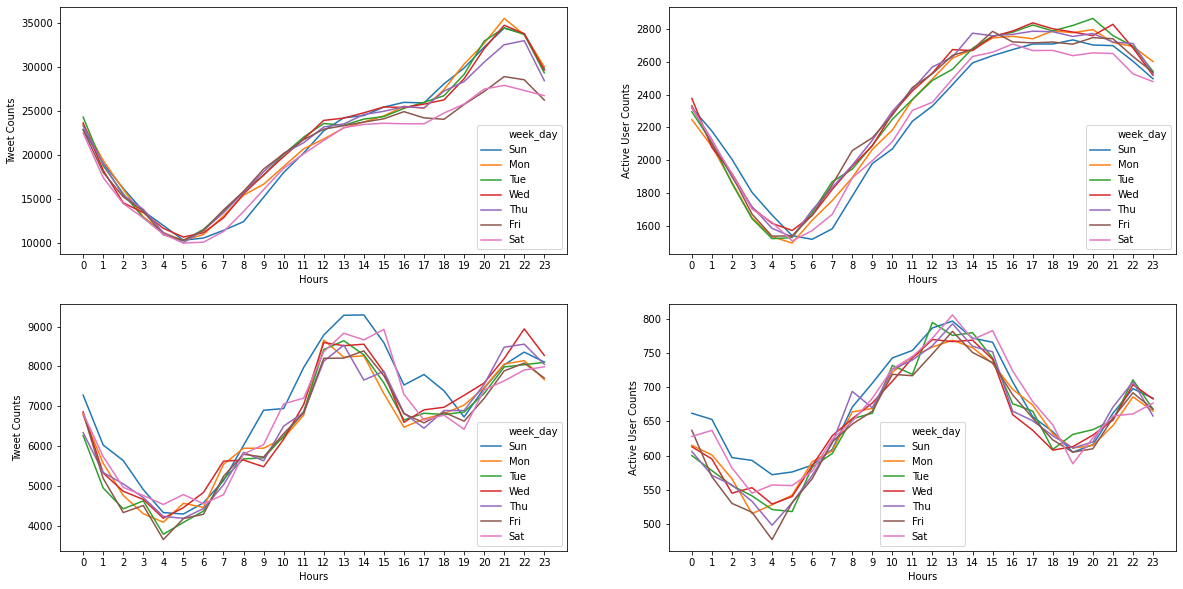

In [26]:
fig, ax = plt.subplots(2, 2, figsize = (20, 10))

sns.lineplot(data = tweet_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,0].set_xlabel('Hours')
ax[0,0].set_ylabel('Tweet Counts')
ax[0,0].set_xticks(np.arange(0, 24))

sns.lineplot(data = user_time_west, x = 'hour', y = 'count', hue = 'week_day', ax = ax[0,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[0,1].set_xlabel('Hours')
ax[0,1].set_ylabel('Active User Counts')
ax[0,1].set_xticks(np.arange(0, 24))

sns.lineplot(data = tweet_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,0],
             hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,0].set_xlabel('Hours')
ax[1,0].set_ylabel('Tweet Counts')
ax[1,0].set_xticks(np.arange(0, 24))

sns.lineplot(data = user_time_east, x = 'hour', y = 'count', hue = 'week_day', ax = ax[1,1],
            hue_order = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
ax[1,1].set_xlabel('Hours')
ax[1,1].set_ylabel('Active User Counts')
ax[1,1].set_xticks(np.arange(0, 24))

plt.show()

### Cluster Analysis

In [27]:
ego_network = pd.read_csv("../Data/EgoNetworks.txt", sep = '\t')

In [28]:
ego_alter_list = languages_with_alter['ID'].tolist()

print(len(ego_alter_list))
ego_network = ego_network[(ego_network['followerID'].isin(ego_alter_list)) 
                          & (ego_network['followeeID'].isin(ego_alter_list))]
ego_network.head()

2492816


egoID  followerID  followeeID
0      1           1     1573741
1      1           1     1662720
2      1           1     1968904
3      1           1     1970142
4      1           1     1970507

In [29]:
mapping_id_language = dict(zip(languages_with_alter['ID'], languages_with_alter['lang']))

def assign_lang(id):
    return mapping_id_language[id]

ego_network['lang1'] = ego_network['followerID'].apply(assign_lang)
ego_network['lang2'] = ego_network['followeeID'].apply(assign_lang)
ego_network['same_lang'] = np.where(ego_network['lang1'] == ego_network['lang2'], True, False)
ego_network['same_lang'].value_counts()

True     2972010
False     927051
Name: same_lang, dtype: int64

In [30]:
language_order = languages_stat.index.tolist()
mapping_language = dict(zip(language_order, [i for i in range(0, 15)]))

rows, cols = (15, 15) 
connection = [[0 for i in range(cols)] for j in range(rows)] 
follow_pair = list(zip(ego_network['lang1'], ego_network['lang2']))

for i, v in enumerate(follow_pair):
    if follow_pair[i][0] in language_order and follow_pair[i][1] in language_order:
        connection[mapping_language[follow_pair[i][0]]][mapping_language[follow_pair[i][1]]] += 1

connection_dataframe = pd.DataFrame(connection, columns = language_order, index = language_order)  
connection_dataframe.head(15)

en-gb    th    nl     de     it     ko     fr      tr     ru     id  \
en-gb   1335    11   108    246    318     20    725     200    166    344   
th        54  1711     5     13      6    180     28      11     11     67   
nl       200     0  9361    189     47      3    137     167     41     52   
de       468     5   237  16748    156    149    553     827    315     41   
it      2619     3    62    190  16473     10    282     138     67    288   
ko        93     2     7    150     16  10592     50      27     20     18   
fr       907     5   130    311    193     38  32447     523    262    161   
tr       604     5   161    820     79     26    363  106747    333    149   
ru       690     6   169    412    197     98    730     850  60135    459   
id       714    29    95    141    101    335    161     328     60  30963   
ar      1131     9    68    192     80     86    778     755    261    276   
pt       806     5   156    292    463    127    440    1513   1043    729   
ja       541    23    19    243     30    584    108     119    321    103   
es      4552    38   495   1441   1539    358   1860    5182   1773   1209   
en     20755  1220  5957  10500   5289   3458  11502   12387   8117  34995   

           ar      pt      ja      es       en  
en-gb     563     585      66    1730    20915  
th         15      40      60      94     5819  
nl         57     143       6     318     9505  
de        216     344     246    1727    18918  
it         84     583      19    1480    13661  
ko         48     114     312     132     5331  
fr       1680     672     174    1699    41378  
tr        857     559     110     877    21925  
ru       1672     732     515    1474    48214  
id        319     305     226     807    54220  
ar     208066     905     361    1543    66883  
pt       3506  156655     577    9935    57374  
ja        500     319  226120     400    15099  
es      12557   12678     848  398216   149450  
en      63659   35152   13850   54806  1696441

In [31]:
fig, ax = plt.subplots(15, 1, figsize = (20, 75), dpi = 300)

for i in range(15):
    ax[i].set(yscale = 'log')
    sns.barplot(x = languages_stat.index, y = connection[i], ax = ax[i])

plt.show()

# Add internationality

In [52]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("../Data/EgoNetworks.txt", sep = '\t')
languages['internationality'] = 0
#for ego, lang in  zip(languages['ID'], languages['lang']):
#    languages['internationality'].loc[ego]
languages

ID  IsEgo  followers_count  friends_count  statuses_count lang  \
0          1   True             30.0             28             9.0   en   
1          2   True              2.0              8             7.0   en   
2          3   True              1.0              0             0.0   fr   
3          4   True              3.0              3            68.0   en   
4          5   True             65.0            118           748.0   fr   
...      ...    ...              ...            ...             ...  ...   
33298  34002   True              0.0              0             0.0   ar   
33299  34003   True            194.0             95           370.0   es   
33300  34004   True              0.0              0             0.0   id   
33301  34005   True              1.0             19             0.0   pt   
33302  34006   True              0.0              0             0.0   en   

       area  internationality  
0      West                 0  
1      West                 0  
2      West                 0  
3      West                 0  
4      West                 0  
...     ...               ...  
33298  East                 0  
33299  West                 0  
33300  East                 0  
33301  West                 0  
33302  West                 0  

[33302 rows x 8 columns]

In [48]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("../Data/EgoNetworks.txt", sep = '\t')

# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages_with_alter['ID'], languages_with_alter['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

ego_networks = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                               (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

ego_networks = pd.merge(ego_networks, languages[['ID','lang']], left_on='egoID', right_on='ID')
ego_networks['followee_lang'] = ego_networks[ ego_networks['egoID'].isin(languages[ languages['IsEgo']==True ]['ID']) ]['followeeID'].apply(get_lang)

ego_networks = ego_networks.groupby(['egoID','lang','followee_lang']).size().to_frame('size')
ego_networks.reset_index(level=['egoID','lang','followee_lang'], inplace=True)
ego_networks['internationality'] = 1-ego_networks['size'][ ego_networks['lang']==ego_networks['followee_lang'] ] / ego_networks.groupby(['egoID'])['size'].sum()
languages = pd.merge(languages, ego_networks[['egoID', 'internationality']], left_on='ID', right_on='egoID')
languages

Empty DataFrame
Columns: [ID, IsEgo, followers_count, friends_count, statuses_count, lang, area, internationality_x, egoID, internationality_y]
Index: []

# Usupervised Learning

I would like to get the same cluster of the culture

In [ ]:
# Load the ego networks as DataFrame
ego_networks = pd.read_csv("Data/EgoNetworks.txt", sep = '\t')
ego_networks

In [ ]:
# Method needs the languages df
languages

In [ ]:
# Filter out rows with egoID, followerID and followeeID which do not have language information
ego_networks_lang = ego_networks[(ego_networks['egoID'].isin(languages['ID'])) & 
                                (ego_networks['followerID'].isin(languages['ID'])) & 
                                (ego_networks['followeeID'].isin(languages['ID']))]

In [ ]:
print("Original ego_networks df had %d rows, but the new ego_networks_lang df has %d rows" 
      %(ego_networks.shape[0], ego_networks_lang.shape[0]))

In [ ]:
# Ignore SettingWithCopyWarning - reference: https://www.dataquest.io/blog/settingwithcopywarning/
pd.set_option('mode.chained_assignment', None)

In [ ]:
# Create dictionary mapping between users and their languages 
user_lang = dict(zip(languages['ID'], languages['lang']))

# Function to return user language from ID
def get_lang(ID):
    return user_lang[ID]

# Add new column with user languages for followers
ego_networks_lang['follower_lang'] = ego_networks_lang['followerID'].apply(get_lang)
# Add new column with user languages for followees
ego_networks_lang['followee_lang'] = ego_networks_lang['followeeID'].apply(get_lang)

In [ ]:
ego_networks_lang.head()

In [ ]:
# List of languages
lang_names = ['cs', 'fi', 'sv', 'pl', 'da', 'ru', 'fr', 'ca', 'nl', 'de', 'pt', 'it', 'es', 'en-gb', 'en', 
              'ar', 'id', 'tr', 'zh-tw', 'zh-cn', 'ja', 'th', 'ko', 'fil', 'msa']

In [ ]:
# Add new columns for each language for followers
#for lang_code in lang_names:
    #ego_networks_lang['follower_lang_' + lang_code] = ego_networks_lang['follower_lang'].apply(lambda x: 1 if x == lang_code else 0)

# Add new columns for each language for followees
for lang_code in lang_names:
    ego_networks_lang['followee_lang_' + lang_code] = ego_networks_lang['followee_lang'].apply(lambda x: 1 if x == lang_code else 0)

In [ ]:
ego_networks_lang.head()

In [ ]:
# Drop the irrelevant columns
ego_networks_lang = ego_networks_lang.drop(columns = ['followerID', 'followeeID', 'follower_lang', 'followee_lang'])
ego_networks_lang.head()

In [ ]:
# Create new df, Group by egoID to give the final df
ml_dataset = ego_networks_lang.groupby(['egoID']).sum()

In [ ]:
ml_dataset = ml_dataset.div(ml_dataset.sum(axis=1), axis=0)

users = list(ml_dataset.index)

In [ ]:
from sklearn.preprocessing import StandardScaler

ml_dataset = StandardScaler().fit(ml_dataset).transform(ml_dataset)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(ml_dataset)
#X_reduced_pca = PCA(n_components=2).fit(ml_dataset).transform(ml_dataset)

In [ ]:
dict_lang = dict( zip(list(set(languages[ languages['ID'].isin(users) ]['lang'])), list(range(25)) ))
def color_lang(x):
    return dict_lang[x]

In [ ]:
labels_lang = languages[ languages['ID'].isin(users) ]['lang'].apply(lambda x: color_lang(x))
labels_area = languages[ languages['ID'].isin(users) ]['area'].apply(lambda x: 1 if x=='West' else 0)

predicted = KMeans(n_clusters=2, random_state=0).fit_predict(ml_dataset)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=labels_area)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

Axes3D.plot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], X_reduced_tsne[:,2], c=predicted)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels_area, alpha=0.6)
axs[0].set_title("Original Types (TSNE)")

axs[1].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (TSNE)")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)

axs[0].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels_lang, alpha=0.6)
axs[0].set_title("Original Types (PCA)")

axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=predicted, alpha=0.6)
axs[1].set_title("Discovered clusters (PCA)")

In [ ]:
# List of egoIDs in the dataset
ml_egoIDs = ml_dataset.index.tolist()
print(len(ml_egoIDs))

In [ ]:
ml_dataset.to_csv(r'ml_dataset_1.csv', index = False)